### Learning with Ensembles

Focus on the "majority voting" principle: select the class lsbel that has been predicted by the majority of classifiers (e.g. recieved more than 50% of the votes) For multiclass systems use "plurality voting" which is just selecting the modal group. 

Can use same or different algorithms to generate votes

Use binomial distribution (and the binomial coefficient) to get a smaller error rate than any individual classifier alone. Certain assumptions must be made (generally, that errors across classifiers are equal and that models are independent- although these may be relaxed). 

To compare an idealistic endsemble over a range of different base error rates, can implement the probability mass function. 

In [1]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
            for k in range(k_start, int(n_classifier + 1))]
    return sum(probs)

ensemble_error(n_classifier = 11, error = 0.25)

0.034327507019042969

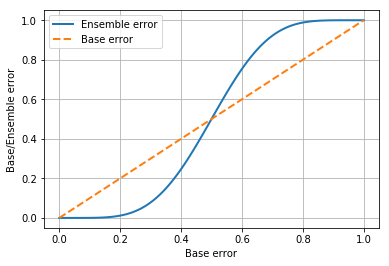

In [2]:
# For a range of different base errors from 0.0 to 1.0

import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
import matplotlib.pyplot as plt
plt.plot(error_range, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label = 'Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

Above: Ensemble error ALWAYS performs better than individual base classifiers as long as base classifiers perform better than random guessing.

### Implementing a simple majority vote classifier

In [6]:
#### Concept of weighted majority (i.e., giving one classifier more votes than others)

import numpy as np
np.argmax(np.bincount([0, 0, 1],
                     weights=[0.2, 0.2, 0.6]))

1

In [7]:
### Based on class probabilites

ex = np.array([[0.9,0.1],
             [0.8, 0.2],
             [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
print(p)
print(np.argmax(p))

[ 0.58  0.42]
0


In [53]:
# implement a MajorityVoteClassifier 

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator 

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ A Majority vote ensemble classifier 
    
    Params
    --------------
    
    classifiers: array-lline, shape = n_classifiers
        Different classifiers for the ensemble
        
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediciton is based on the argmax
        of the class lables. Else if 'probability' the argmax of the
        sum of the probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    Weights: array-like, shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are provided, the 
        classifiers are weighted by importance; Uses uniform weights
        if weights = None"""
    
    
    def __init__(self, classifiers, vote = 'classlabel', weights = None):
        
        self.classifiers = classifiers
        
        self.named_classifiers = {key: value for key, value in
                                 _name_estimators(classifiers)}
        
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        
        """Fit Classifiers.
        parameters
        -----------
        
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples
            
        y: array-like, shape = [n_samples]
            vector of target class labels.
            
        Returns
        --------
        self: object"""
        
    # Use LabelEncoder to ensure class labels start with 0 (important for np.argmax in self.predict)

        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                  self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self 
    
    def predict_proba(self, X):
        """ Predict class probabilities for X.
        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.
        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.
        """

        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis = 0, weights=self.weights)
        return avg_proba
    
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        -----------
        X: {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        -----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels

        """

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                axis = 1)
        else: # 'classlabel' vote

            # Collect results from clf.predict calls 
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
            lambda x:
            np.argmax(np.bincount(x, weights = self.weights)), axis= 1, arr = predictions)

        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def get_params(self, deep=True):
        """Get classifier parameter names for Gridsearch"""

        if not deep:
            return super(MajoirtyVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s_%s' % (name, key)] = value
            return out

In [15]:
def predict(self, X):
    """ Predict class labels for X.
    
    Parameters
    -----------
    X: {array-like, sparse matrix},
        Shape = [n_samples, n_features]
        Matrix of training samples.
    
    Returns
    -----------
    maj_vote : array-like, shape = [n_samples]
        Predicted class labels
        
    """
    
    if self.vote == 'probability':
        maj_vote = np.argmax(self.predict_proba(X),
                            axis = 1)
    else: # 'classlabel' vote
        
        # Collect results from clf.predict calls 
        predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
        
        maj_vote = np.apply_along_axis(
        lambda x:
        np.argmax(np.bincount(x, weights = self.weights)), axis= 1, arr = predictions)
        
    maj_vote = self.lablenc_.inverse_transform(maj_vote)
    return maj_vote
    
def predict_proba(self, X):
    """ Predict class probabilities for X.
    Parameters
    ----------
    X : {array-like, sparse matrix},
        shape = [n_samples, n_features]
        Training vectors, where n_samples is
        the number of samples and
        n_features is the number of features.
    Returns
    ----------
    avg_proba : array-like,
        shape = [n_samples, n_classes]
        Weighted average probability for
        each class per sample.
    """
    
    probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
    avg_proba = np.average(probas, axis = 0, weights=self.weights)
    return avg_proba

def get_params(self, deep=True):
    """Get classifier parameter names for Gridsearch"""
    
    if not deep:
        return super(MajoirtyVoteClassifier, self).get_params(deep=False)
    else:
        out = self.named_classifiers.copy()
        for name, step in six.iteritems(self.named_classifiers):
            for key, value in six.iteritems(step.get_params(deep=True)):
                out['%s_%s' % (name, key)] = value
        return out

In [59]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'}
      Default: 'classlabel'
      If 'classlabel' the prediction is based on
      the argmax of class labels. Else if
      'probability', the argmax of the sum of
      probabilities is used to predict the class label
      (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers]
      Optional, default: None
      If a list of `int` or `float` values are
      provided, the classifiers are weighted by
      importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for
                                  key, value in
                                  _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        # Use LabelEncoder to ensure class labels start
        # with 0, which is important for np.argmax
        # call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                              self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            Shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X),
                                 axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in
                                      self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                           lambda x:
                           np.argmax(np.bincount(x,                                             
                                        weights=self.weights)),
                           axis=1,
                           arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is
            the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for
            each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, 
                               axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                        step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### Combining different algorithms for classification with majority vote

In [39]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 1)


In [40]:
### Now train three different classifiers 
## LogRegression, decision tree, and k-NN
## use 10 fold CV before combining into an ensemble classifier

from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty = 'l2',
                         C=0.001,
                         random_state = 0)
clf2 = DecisionTreeClassifier(max_depth = 1,
                             criterion = 'entropy',
                             random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1, p = 2, metric = 'minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X= X_train,
                            y=y_train, cv = 10, scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [60]:
### Define a majority vote calssifier for these 3 methods

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X= X_train, y=y_train, cv = 10, scoring = 'roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
         % (scores.mean(), scores.std(), label))
    

Accuracy: 0.92 (+/- 0.20) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


### Evaluating and Tuning the ensemble classifier

Will compute ROC curves from the test set to check if MajorityVoteClassifier generalizes well to unseen data

Not for model selection, just to report an unbiased estimate of the generalization performance of the classifier system


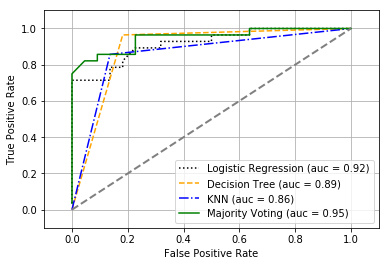

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, 
                                    y_score = y_pred)
    roc_auc = auc(x=fpr, y = tpr)
    plt.plot(fpr, tpr,
            color = clr,
            linestyle = ls,
            label = '%s (auc = %0.2f)' %(label, roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],
        linestyle = '--',
        color = 'gray',
        linewidth = 2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

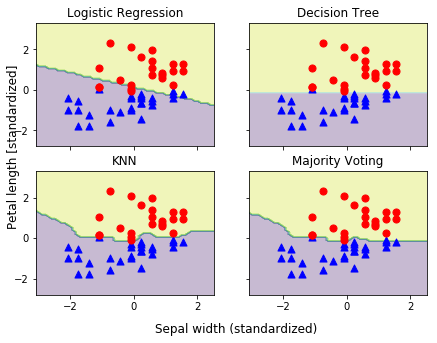

In [43]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows = 2, ncols = 2,
                       sharex = 'col',
                       sharey = 'row',
                       figsize=(7, 5))

for idx, clf, tt in zip(product([0,1], [0,1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c='blue',
                                 marker='^',
                                 s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train == 1, 1],
                                 c= 'red', 
                                 marker = 'o',
                                 s = 50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s = 'Sepal width (standardized)',
        ha = 'center', va = 'center', fontsize = 12)

plt.text(-10.5, 4.5,
        s = 'Petal length [standardized]',
        ha = 'center', va = 'center',
        fontsize = 12, rotation = 90)
plt.show()

In [44]:
mv_clf.get_params()


{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier_class_weight': None,
 'decisiontreeclassifier_criterion': 'entropy',
 'decisiontreeclassifier_max_depth': 1,
 'decisiontreeclassifier_max_features': None,
 'decisiontreeclassifier_max_leaf_nodes': None,
 'decisiontreeclassifier_min_impurity_decrease': 0.0,
 'decisiontreeclassifier_min_impurity_split': None,
 'decisiontreeclassifier_min_samples_leaf': 1,
 'decisiontreeclassifier_min_samples_split': 2,
 'decisiontreeclassifier_min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier_presort': False,
 'decisiontreeclassifier_random_state': 0,
 'decisiontreeclassifier_splitter': 'best',
 'pip

In [62]:
from sklearn.grid_search import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1,2],
         'pipeline-1__clf__C' : [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, param_grid = params,
                   cv = 10,
                   scoring = 'roc_auc')

grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'pipeline-1__clf__C': [0.001, 0.1, 100.0], 'decisiontreeclassifier__max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [65]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))

0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.967+/-0.05 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.967+/-0.05 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.000+/-0.00 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


In [66]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}


In [67]:
print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 1.00


Above technique is called "stacking" can read more about it in 

Wolpert, D. H. Stacked Generalization. neural Networks, 5(2) 241-259 1992

### Bagging- Building Ensemble Models from Boorstrapped Samples

Bagging is fitting ensemble learners using bootstrapped samples with replacement

Bagging is short for bootstrap aggregating.

Usually used with unpruned decision trees

Works well for highly variable models and small datasets

Can read the original article:
Breiman, L. Bagging Predictors Machine Learning. 24(2) 123-140, 1996

In [68]:
import pandas as pd
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

In [69]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
                  'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
                  'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                  'Proline']

df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [70]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split

le=LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state = 1)

In [71]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',
                             max_depth=None,
                             random_state = 1)
bag = BaggingClassifier(base_estimator = tree,
                       n_estimators = 500,
                       max_samples = 1.0,
                       max_features = 1.0,
                       bootstrap = True,
                       bootstrap_features = False,
                       n_jobs = 1,
                       random_state = 1)

In [72]:
### calculate accuracy score of the prediciton of traning and test sets
## compare bagging classifier to unpruned decision tree

#Unpruned Decision Tree
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.833


In [74]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.896


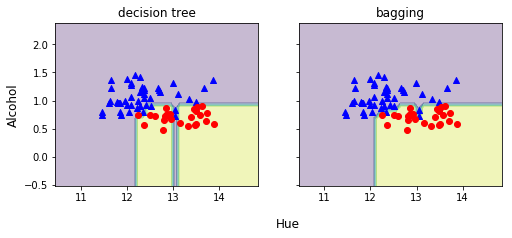

In [76]:
### Comparing decision regions
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols = 2, sharex = 'col', 
                       sharey = 'row', figsize = (8,3))

for idx, clf, tt in zip([0,1], [tree, bag], ['decision tree', 'bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                      X_train[y_train==0, 1],
                      c='blue', marker = '^')
    axarr[idx].scatter(X_train[y_train==1, 0],
                      X_train[y_train==1,1],
                      c='red', marker = 'o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize = 12)
plt.text(10.2, -1.2, s = 'Hue', ha = 'center', va = 'center', fontsize = 12)
plt.show()

### Leveraging weak learners via adaptive boosting

Key Concept of Boosting: focus on training samples that are hard to classify and train models on the misclassifications to improve the ensemble.

Procedure:

1. Draw a random subset of training samples d without replacement from training set D to train a weak learner C1.
2. Draw a second random training subset d2 without replacement form the training set and add 50% of the samples that were previously misclassified to train a weak learner C2
3. Find the trianing samples d3 in the trianing set D on which C1 and C2 disagree and train a third weak learner C3
4. Combine weak learners C1, C2, and C3 in majority vote  

May lead to decrease in bias and variance compared to bagging-- still typically overfit

*Adaboost* uses the whole training set to train the weak learners where the training samples are reweighted after each iteration to build a strong classifier that learns from the mistakes of weak learners

In [85]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion= 'entropy',
                             max_depth = 1)

ada = AdaBoostClassifier(base_estimator = tree,
                        n_estimators = 500, learning_rate = 0.1,
                        random_state = 0)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.845/0.854


In [86]:
ada = ada.fit(X_train, y_train)
y_train_pred2 = ada.predict(X_train)
y_test_pred2 = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred2)
ada_test = accuracy_score(y_test, y_test_pred2)
print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))


AdaBoost train/test accuracies 1.000/0.875


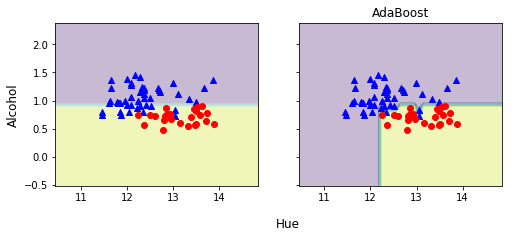

In [89]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)   
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], 
                       c='blue', 
                       marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], 
                       c='red',
                       marker='o')
axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, 
         s='Hue', 
         ha='center', 
         va='center', 
         fontsize=12)    
plt.show()